In [ ]:
!pip install opencv-python
!pip install tqdm
!pip install imgaug
!pip install imageio

In [40]:
import os
import cv2
import io
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imageio.v2 as imageio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [41]:
# Chargement des images depuis le dataset
image_folder = "./dataset/images/"
images = os.listdir(image_folder)
images = [os.path.join(image_folder, img) for img in images]
images[30]

'./dataset/images/acc1-6-_jpg.rf.0acbfc206f6e8d9021f00903414e7909.jpg'

In [42]:
# Chargement des labels depuis le dataset
labels_folder = "./dataset/labels/"
labels = os.listdir(labels_folder)
labels = [os.path.join(labels_folder, label) for label in labels]
labels[30]

'./dataset/labels/acc1-6-_jpg.rf.0acbfc206f6e8d9021f00903414e7909.txt'

In [43]:
len(images), len(labels)

(1258, 1268)

In [44]:
image = imread(images[10])
image.shape

(640, 640, 3)

In [45]:
image

array([[[ 9,  8, 16],
        [11, 10, 18],
        [ 6,  5, 11],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 4,  3, 11],
        [ 8,  7, 13],
        [ 6,  5, 10],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  0,  6],
        [ 4,  3,  9],
        [ 3,  2,  7],
        ...,
        [ 2,  2,  2],
        [ 1,  1,  1],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  2],
        [ 0,  0,  2],
        [ 0,  0,  2],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  2],
        [ 0,  1,  3],
        [ 0,  0,  2],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 2,  2,  0]],

       [[ 2,  3,  5],
        [ 4,  5,  7],
        [ 3,  4,  6],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 3,  3,  1]]], dtype=uint8)

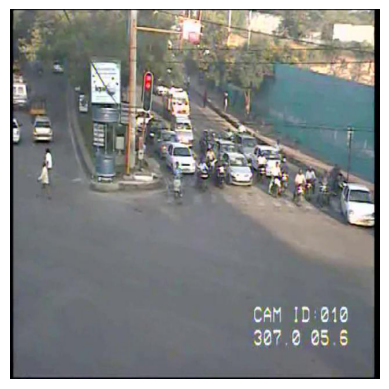

In [46]:
# Affichage de l'image
plt.imshow(image)
plt.axis('off')  # pour cacher les axes
plt.show()

In [47]:
# Fonction permettant d'analyser les coordonnées de la boîte de délimitation à partir d'un fichier texte
def parse_bounding_boxes(text_file_paths):
    bounding_boxes = {}
    for text_file in tqdm(text_file_paths,total=len(text_file_paths)):
        # Déterminer le chemin d'accès au fichier image correspondant
        image_file = text_file.replace('.txt', '.jpg')
        image_file1 = image_file.replace('labels', 'images')
        with open(text_file, 'r') as file:
            data = file.read()
            # Chaque ligne du fichier est une boîte de délimitation distincte.
            boxes = data.strip().split('\n')
            # Analyse de chaque coordonnée de la boîte
            box_coords = [tuple(map(float, box.split())) for box in boxes]
            bounding_boxes[image_file1] = box_coords
    return bounding_boxes

# Appel de la fonction avec nos fichiers texte d'exemple
bounding_boxes = parse_bounding_boxes(labels)
# bounding_boxes['./dataset/images/acc1-6-_jpg.rf.0acbfc206f6e8d9021f00903414e7909.jpg']
bounding_boxes['./dataset/images/test_38_jpg.rf.1f501ba535b33634ce858c2a54022ee1.jpg']
# images[1]

100%|████████████████████████████████████████████████████████████████████████████| 1268/1268 [00:00<00:00, 2812.43it/s]


[(0.0, 0.515625, 0.6015625, 0.3359375, 0.43984375),
 (0.0, 0.27890625, 0.21171875, 0.24453125, 0.21015625)]

In [48]:
# Fonction qui a partir des boites de delimitation determiner classifie nos cibles et le convertie en numpy array
def get_targets(data):
    targets_array = []
    for key, value in data.items():
        if value == [()]:
            targets_array.append(1)
        else:
            targets_array.append(0)
    return np.array(targets_array)

targets = get_targets(bounding_boxes)
targets

array([1, 1, 1, ..., 1, 1, 1])

In [49]:
targets.shape

(1268,)

In [50]:
# Nombre d'occurences de chaque classe
np.unique(targets, return_counts=True)

(array([0, 1]), array([711, 557], dtype=int64))

In [51]:
# Fonction de cleaning qui associe chaque images a son label file et supprime les duplicats
def clean_data(image_paths, targets_path):
    valid_image_paths = []
    valid_targets_path = []

    # Construire un ensemble de noms de base pour les chemins d'images et de cibles
    image_bases = {os.path.splitext(os.path.basename(path))[0] for path in image_paths}
    target_bases = {os.path.splitext(os.path.basename(path))[0] for path in targets_path}

    # Filtrer les chemins d'images et de cibles pour ne garder que les correspondances valides
    for base in image_bases & target_bases:
        image_path = next((path for path in image_paths if base in path), None)
        target_path = next((path for path in targets_path if base in path), None)
        if image_path and target_path:
            valid_image_paths.append(image_path)
            valid_targets_path.append(target_path)

    return valid_image_paths, valid_targets_path

# Exemple d'utilisation
images, labels = clean_data(images, labels)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 448.78it/s]


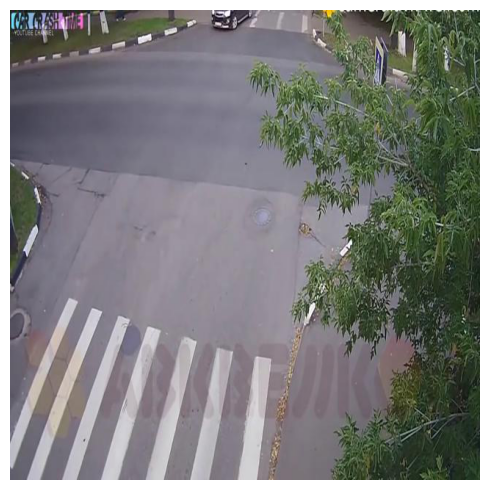

In [52]:
# Fonction permettant de dessiner une seule boîte de délimitation sur l'image
def draw_box(image_data, box, color='green'):
    # Déballer les valeurs de la boîte
    if box: 
        _, x_center, y_center, width, height = box
        # Convertir en x, y à partir du haut de la page gauche et en largeur et hauteur en pixels
        x = (x_center - (width / 2)) * image_data.size[0]
        y = (y_center - (height / 2)) * image_data.size[1]
        width_pixels = width * image_data.size[0]
        height_pixels = height * image_data.size[1]

        # Création du rectangle et l'ajouter à la parcelle ou a eu lieu l'acciden
        rect = patches.Rectangle((x, y), width_pixels, height_pixels, linewidth=1, edgecolor=color, facecolor='none')
        return rect
    else:
        return None

# Fonction de visualisation des boîtes de délimitation
def visualize_boxes(images, boxes):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, 10*len(images)))
    if len(images) == 1:
        axs = [axs]  # Rendre l'itération possible

    for ax, image_path in zip(axs, images):
        # Chargement de l'image
        with open(image_path, 'rb') as img_file:
            image_data = Image.open(io.BytesIO(img_file.read()))
        ax.imshow(image_data)
        
        # On dessine les boîtes
        if image_path in boxes:
            for box in boxes[image_path]:
                rect = draw_box(image_data, box)
                if rect:
                    ax.add_patch(rect)
                
        # Supprimer l'axe pour une meilleure visualisation
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_boxes([images[10]], parse_bounding_boxes([labels[10]]))

In [53]:
def contains_non_empty_tuple(lst):
    for element in lst:
        if isinstance(element, tuple) and len(element) > 0:
            return True
    return False

In [54]:
def augment_and_save_images(image_paths, bounding_boxes, img_save_dir, label_save_dir):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # flip 50% des images horizontalement
        iaa.Affine(
            rotate=(-25, 25),  # rotation aléatoire entre -25 et 25 degrés
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # translation
            scale=(0.8, 1.2)  # zoom entre 80% et 120%
        ),
        iaa.Multiply((0.8, 1.2)),  # changer la luminosité
        iaa.GaussianBlur(sigma=(0, 1.0))  # flou gaussien
    ])

    if not os.path.exists(img_save_dir):
        os.makedirs(img_save_dir)
    if not os.path.exists(label_save_dir):
        os.makedirs(label_save_dir)

    augmented_image_paths = []
    augmented_bounding_boxes = []

    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        image = imageio.imread(image_path)
        if contains_non_empty_tuple(bounding_boxes.get(image_path)):
            bbs = BoundingBoxesOnImage([
                BoundingBox(
                    x1=box[1] * image.shape[1] - box[3] * image.shape[1] / 2,
                    y1=box[2] * image.shape[0] - box[4] * image.shape[0] / 2,
                    x2=box[1] * image.shape[1] + box[3] * image.shape[1] / 2,
                    y2=box[2] * image.shape[0] + box[4] * image.shape[0] / 2)
                for box in bounding_boxes[image_path]
            ], shape=image.shape)
        else:
            bbs = BoundingBoxesOnImage([], shape=image.shape)

        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        base_filename = os.path.basename(image_path)
        image_save_path = os.path.join(img_save_dir, f"aug_{i}_{base_filename}")
        label_save_path = os.path.join(label_save_dir, f"aug_{i}_{base_filename}").replace('.jpg', '.txt')
        
        imageio.imwrite(image_save_path, image_aug)
        augmented_image_paths.append(image_save_path)
        
        with open(label_save_path, 'w') as file:
            for bb in bbs_aug.bounding_boxes:
                if bb.is_fully_within_image(image_aug):
                    # Normaliser les coordonnées pour le fichier de sortie
                    x_center = (bb.x1 + bb.width / 2) / image_aug.shape[1]
                    y_center = (bb.y1 + bb.height / 2) / image_aug.shape[0]
                    width = bb.width / image_aug.shape[1]
                    height = bb.height / image_aug.shape[0]
                    file.write(f'0 {x_center} {y_center} {width} {height}\n')
        augmented_bounding_boxes.append(label_save_path)

        # Visualization
        # fig, ax = plt.subplots(figsize=(10, 10))
        # bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255], alpha=0.8)
        # ax.imshow(image_aug)
        # plt.show()

    return augmented_image_paths, augmented_bounding_boxes

augmented_paths, augmented_labels = augment_and_save_images(images, bounding_boxes, image_folder, labels_folder)
augmented_paths, augmented_labels

100%|██████████████████████████████████████████████████████████████████████████████| 1258/1258 [01:16<00:00, 16.54it/s]


(['./dataset/images/aug_0_ezgif-frame-027_jpg.rf.369d02b727a9be39f2e3fb352ef4d3e6.jpg',
  './dataset/images/aug_1_test_10_jpg.rf.81e161782c1db0c9a8af7c369aba279b.jpg',
  './dataset/images/aug_2_test7_38_jpg.rf.d1a1d7437563a7ccd5b4198ee0391077.jpg',
  './dataset/images/aug_3_test24_3_jpg.rf.1b834e282195ca503d811296123aa279.jpg',
  './dataset/images/aug_4_test22_23_jpg.rf.a084e7b36739a0f79fb3d2774a22094b.jpg',
  './dataset/images/aug_5_test_40_jpg.rf.5761b171e2ea6d5d05cf77d66d89eb36.jpg',
  './dataset/images/aug_6_acc1-4-_jpg.rf.df4b93de5e73a19502a03b22eae18a62.jpg',
  './dataset/images/aug_7_test11_46_jpg.rf.181e153284592da21ecf8b48cda6a8b0.jpg',
  './dataset/images/aug_8_test25_6_jpg.rf.c01e57bf317a59aea9c822506bafdb36.jpg',
  './dataset/images/aug_9_test10_3_jpg.rf.2695089cd3a6d918d097c85cdd6e9c10.jpg',
  './dataset/images/aug_10_test19_9_jpg.rf.d625054fa73e2a1736de776085d75a63.jpg',
  './dataset/images/aug_11_test29_22_jpg.rf.16c6b94daefb29048512135c328cd577.jpg',
  './dataset/images

In [55]:
images = os.listdir(image_folder)
images = [os.path.join(image_folder, img) for img in images]

labels = os.listdir(labels_folder)
labels = [os.path.join(labels_folder, label) for label in labels]

bounding_boxes = parse_bounding_boxes(labels)
len(images), len(labels)

100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 546.81it/s]


(2516, 2526)

In [56]:
images, labels = clean_data(images, labels)
len(images), len(labels)

(2516, 2516)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1453.38it/s]


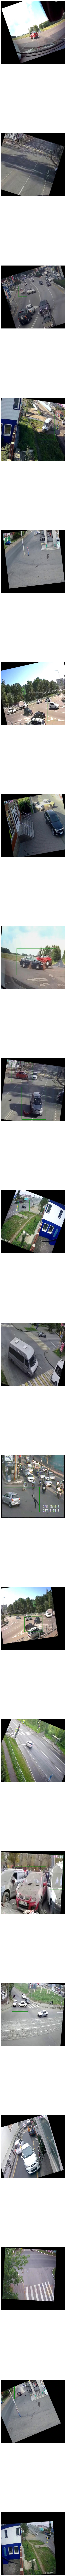

In [57]:
visualize_boxes(images[:20], parse_bounding_boxes(labels[:20]))

In [76]:
def extract_features_and_bounding_boxes(image_paths, bounding_boxes):
    data = []  # Pour stocker les caractéristiques et les informations des boîtes englobantes

    for image_path in tqdm(image_paths,total=len(image_paths)):
        image = imread(image_path)
        image_gray = rgb2gray(image)
        image_resized = resize(image_gray, (128, 64), anti_aliasing=True)

        # Extraction des caractéristiques HOG
        fd_hog = hog(image_resized, orientations=8, pixels_per_cell=(16, 16),
                     cells_per_block=(1, 1), feature_vector=True)

        # Vérifier si des boîtes englobantes existent pour cette image
        if image_path in bounding_boxes:
            for box_info in bounding_boxes[image_path]:
                if not box_info:
                    box = [1.0, 0.0, 0.0, 1.0, 1.0]
                else:
                    box = list(box_info)  # box est une liste: [classe, x_center, y_center, width, height]

                # Combiner les caractéristiques HOG et les attributs de la boîte dans une seule liste
                combined_features = list(fd_hog) + box
                data.append(combined_features)
        else:
            # Si aucune boîte n'est trouvée, utiliser des valeurs par défaut (pourrait indiquer "pas d'accident" par exemple)
            box = [1.0, 0.0, 0.0, 1.0, 1.0]  # Exemple de valeurs par défaut
            combined_features = list(fd_hog) + box
            data.append(combined_features)

    # Noms des colonnes pour le DataFrame
    feature_names = [f'feature_{i}' for i in range(len(data[0])-5)] + ['class', 'x_center', 'y_center', 'width', 'height']

    # Création du DataFrame
    df = pd.DataFrame(data, columns=feature_names)
    
    return df

df = extract_features_and_bounding_boxes(images, bounding_boxes)
df.shape

100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [02:13<00:00, 18.88it/s]


(2596, 261)

In [77]:
df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.001424   0.001560   0.920118   0.318994   0.227199   0.000000   
1   0.443582   0.443582   0.233199   0.211861   0.322167   0.394884   
2   0.020028   0.137951   0.088841   0.986243   0.000058   0.000000   
3   0.824562   0.172485   0.023496   0.028592   0.192090   0.008127   
4   0.386903   0.386903   0.386903   0.386903   0.273177   0.164961   

   feature_6  feature_7  feature_8  feature_9  ...  feature_251  feature_252  \
0   0.000000   0.001120   0.671458   0.048021  ...     0.000000     0.000000   
1   0.379003   0.322235   0.379685   0.323290  ...     0.000000     0.000000   
2   0.000000   0.000000   0.196548   0.550339  ...     0.384977     0.303086   
3   0.046803   0.499822   0.452604   0.248449  ...     0.232375     0.416893   
4   0.386903   0.386903   0.414082   0.414082  ...     0.592646     0.805462   

   feature_253  feature_254  feature_255  class  x_center  y_center     width  \
0     0.000000     0.000000     0.000000    1.0  0.000000  0.000000  1.000000   
1     0.000000     0.038566     0.325207    1.0  0.000000  0.000000  1.000000   
2     0.137467     0.384977     0.384977    0.0  0.334069  0.407516  0.133290   
3     0.335736     0.416893     0.416893    0.0  0.709788  0.458057  0.260497   
4     0.000000     0.000000     0.000000    1.0  0.000000  0.000000  1.000000   

     height  
0  1.000000  
1  1.000000  
2  0.161926  
3  0.402738  
4  1.000000  

[5 rows x 261 columns]

In [78]:
X = df.drop(['class', 'x_center', 'y_center', 'width', 'height'], axis=1)  # Caractéristiques
y = df[['class', 'x_center', 'y_center', 'width', 'height']]  # Cibles (boîtes englobantes)
X.shape, y.shape

((2596, 256), (2596, 5))

In [79]:
# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Affichage de la taille des ensembles pour vérification
print ('X: ({}, {})'.format(*X.shape))
print ('y: ({}, {})'.format(*y.shape))
print ('X_train: ({}, {})'.format(*X_train.shape))
print ('y_train: ({}, {})'.format(*y_train.shape))
print ('X_test: ({}, {})'.format(*X_test.shape))
print ('y_test: ({}, {})'.format(*y_test.shape))

X: (2596, 256)
y: (2596, 5)
X_train: (2076, 256)
y_train: (2076, 5)
X_test: (520, 256)
y_test: (520, 5)


In [81]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Adapter pour la classification binaire, en utilisant 'class' comme cible
y_train_binary = y_train['class']
y_test_binary = y_test['class']

# # Création et entraînement du modèle SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train_binary)

SVC(kernel='linear', probability=True)

In [82]:
from sklearn.ensemble import RandomForestClassifier

# Création et entraînement du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train_binary)

RandomForestClassifier(n_estimators=200)

In [83]:
# Évaluation du modèle SVM
svm_predictions = svm_model.predict(X_test)
print("Évaluation du modèle SVM:")
print(classification_report(y_test_binary, svm_predictions))

# Évaluation du modèle Random Forest
rf_predictions = rf_model.predict(X_test)
print("Évaluation du modèle Random Forest:")
print(classification_report(y_test_binary, rf_predictions))


Évaluation du modèle SVM:
              precision    recall  f1-score   support

         0.0       0.69      0.64      0.66       250
         1.0       0.69      0.73      0.71       270

    accuracy                           0.69       520
   macro avg       0.69      0.68      0.68       520
weighted avg       0.69      0.69      0.69       520

Évaluation du modèle Random Forest:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       250
         1.0       0.93      0.96      0.94       270

    accuracy                           0.94       520
   macro avg       0.94      0.94      0.94       520
weighted avg       0.94      0.94      0.94       520



In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot des courbes d'apprentissage
plot_learning_curve(svm_model, "Courbe d'apprentissage (SVM)", X_train, y_train_binary, cv=5)
plot_learning_curve(rf_model, "Courbe d'apprentissage (Random Forest)", X_train, y_train_binary, cv=5)
plt.show()

In [ ]:
images[11],bounding_boxes[images[11]]

In [ ]:
np.unique(targets, return_counts=True)

In [ ]:
# Supposons que new_image_path est le chemin vers votre nouvelle image

# Utilisez la fonction d'extraction de caractéristiques définie précédemment
new_features = extract_features_and_bounding_boxes([images[11]],bounding_boxes[images[11]])
new_features = new_features.drop(['class', 'x_center', 'y_center', 'width', 'height'], axis=1)  # Assurez-vous d'exclure les cibles

# Faire des prédictions avec les deux modèles
svm_pred = svm_model.predict(new_features)
rf_pred = rf_model.predict(new_features)

print(f"Prédiction SVM: {svm_pred}")
print(f"Prédiction Random Forest: {rf_pred}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcul des scores
svm_accuracy = accuracy_score(y_test_binary, svm_predictions)
rf_accuracy = accuracy_score(y_test_binary, rf_predictions)

svm_precision = precision_score(y_test_binary, svm_predictions)
rf_precision = precision_score(y_test_binary, rf_predictions)

svm_recall = recall_score(y_test_binary, svm_predictions)
rf_recall = recall_score(y_test_binary, rf_predictions)

svm_f1 = f1_score(y_test_binary, svm_predictions)
rf_f1 = f1_score(y_test_binary, rf_predictions)

svm_roc_auc = roc_auc_score(y_test_binary, svm_predictions)
rf_roc_auc = roc_auc_score(y_test_binary, rf_predictions)

# Affichage des scores
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

print("SVM Precision:", svm_precision)
print("Random Forest Precision:", rf_precision)

print("SVM Recall:", svm_recall)
print("Random Forest Recall:", rf_recall)

print("SVM F1 Score:", svm_f1)
print("Random Forest F1 Score:", rf_f1)

print("SVM ROC AUC Score:", svm_roc_auc)
print("Random Forest ROC AUC Score:", rf_roc_auc)

In [ ]:
# Globalement, les résultats montrent que le modèle Random Forest surpasse le modèle SVM en termes de précision,
# de rappel, de score F1 et de score ROC AUC, ce qui indique qu'il peut être plus performant pour votre problème de détection.

In [ ]:
# Sauvegarde du model
import pickle

# Sauvegarder le modèle dans un fichier
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)


In [ ]:
# Analyse des Performances du Modèle SVM

# -> Précision (Precision)
# Classe 0 (accident) : La précision est de 0.69, ce qui signifie que 69% des prédictions du modèle comme étant des accidents étaient correctes.
# Classe 1 (pas d'accident) : La précision est également de 0.69, indiquant que 69% des prédictions de non-accidents étaient correctes.
# -> Rappel (Recall)
# Classe 0 (accident) : Le rappel est de 0.64, indiquant que le modèle a correctement identifié 64% des accidents réels.
# Classe 1 (pas d'accident) : Le rappel est de 0.73, signifiant que 73% des non-accidents réels ont été correctement identifiés par le modèle.
# -> Score F1 (F1-score)
# Classe 0 (accident) : Le score F1 est de 0.66, reflétant un équilibre entre la précision et le rappel pour les accidents.
# Classe 1 (pas d'accident) : Le score F1 est de 0.71, un peu plus élevé, reflétant un meilleur équilibre pour les non-accidents.
# -> Précision Globale (Accuracy)
# L'accuracy globale du modèle SVM est de 69%, ce qui signifie que 69% des prédictions totales étaient correctes.

# Analyse des Performances du Modèle Random Forest
# -> Précision (Precision)
# Classe 0 (accident) : La précision est très élevée à 0.95, indiquant une excellente précision dans les prédictions d'accidents.
# Classe 1 (pas d'accident) : La précision est également élevée à 0.94.
# -> Rappel (Recall)
# Classe 0 (accident) : Le rappel est de 0.93, montrant que le modèle a réussi à capturer 93% des accidents réels.
# Classe 1 (pas d'accident) : Le rappel est de 0.95, indiquant une très bonne performance dans l'identification des non-accidents.
# -> Score F1 (F1-score)
# Les scores F1 pour les deux classes sont très élevés, environ 0.94 pour les deux, indiquant un excellent équilibre entre la précision et le rappel.
# -> Précision Globale (Accuracy)
# L'accuracy globale du modèle Random Forest est de 94%, démontrant une excellente performance globale.

# Conclusion
# Le modèle Random Forest outperforme de manière significative le modèle SVM sur toutes les métriques. Cela peut être dû à la capacité des Random Forests à gérer des caractéristiques non linéaires et à leur robustesse face à l'overfitting grâce à l'ensemble learning.
# Le SVM pourrait nécessiter un ajustement plus fin des hyperparamètres, ou il pourrait ne pas être aussi bien adapté à la nature des données que le Random Forest.
# La forte performance du Random Forest suggère qu'il est très bien adapté pour ce problème spécifique de détection d'accidents, avec une précision et un rappel élevés qui garantissent que peu d'accidents sont manqués et que peu de fausses alertes sont générées.